In [1]:
from __future__ import division

import warnings
warnings.filterwarnings("ignore")
%matplotlib notebook
#%matplotlib inline
import time
import random
import numpy as np
from scipy.stats import norm
import scipy.io as sio
import matplotlib as mpl
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections as mc
from scipy.stats import multivariate_normal as mvn
from math import atan2
from tqdm import tqdm_notebook as tqdm
import copy
import datetime

#Torch stuff

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import pdb
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from functools import reduce
from tqdm import tqdm
import random
from importlib import reload


from IPython.display import display, Markdown, Latex

In [2]:
def visualizeSimulation(policy, actions, use_rl, visualize=True, desired_steps = 50):
    nodes = [
    (0.,0.), (100.,0.), (200.,0),
    (0.,100), (100.,100.), (200.,100.),
#     (0.,200), (100.,200.), (200.,200.)
    ]
    edges = [(0, 1),
             (0, 3),
             (1, 2),
             (1, 4),
             (2, 5),
             (3, 4),
#              (3, 6),
             (4, 5),
#              (4, 7),
#              (5, 8),
#              (6, 7),
#              (7, 8)
             ]
    roadmap = policy.roadmap
    env = Simulator(nodes, edges, roadmap, N=150, num_targets=2)
    state = env.reset(visualize=visualize)
    actions = env.get_action_dimensions()
#     print(env.max_entropy)
    reward = []
    for ii in range(desired_steps):
        
#         print(ii)
        if use_rl:
            action = policy(torch.from_numpy(state).float().view(1,-1))
            action_index = np.random.choice(range(actions),p=action.detach().numpy().reshape((actions)))
#             print(action_index)
        else:
            wp = env.get_agent_greedy_waypoint()
            options = env.agent.get_options()
            action_index = options.index(wp)
        s_prime, rr, end_roll = env.step(action_index)
        
        reward.append(rr)
        # reward += rr

        # current_rollout.append((state, action.detach().reshape(-1), action_index, rr))
        if end_roll:
            print('illegal action')
            break
        #
        state = s_prime
        
    return reward, ii, env.get_entropy_over_sim()

<IPython.core.display.Javascript object>


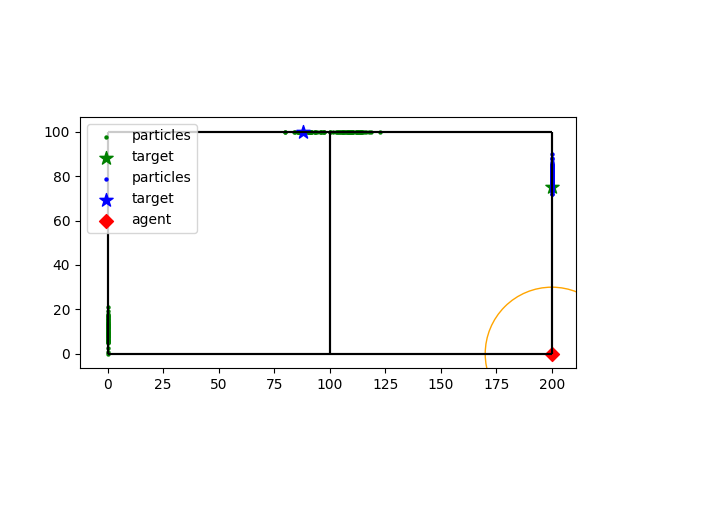

In [3]:
from importlib import reload
# import deep_input
# reload(deep_input)
# from deep_input import Simulator
import simulator
reload(simulator)
from simulator import Simulator
from rl_net import PolicyNetwork, ValueNetwork, AdvantageDataset, PolicyDataset, calculate_returns, calculate_advantages

USE_RL_NET=True

states = 1202
actions = 3
if False:
    # env = gym.make('LunarLander-v2')
    policy = PolicyNetwork(states, actions)
    value = ValueNetwork(states)
    # policy_optim = optim.Adam(policy.parameters(), lr=1e-4, weight_decay=0.01)
    # value_optim = optim.Adam(value.parameters(), lr=1e-3, weight_decay=1)
else:
    policy = torch.load("policy-small-10")
#     value = torch.load("value-900")
    reward, num_steps, entropy_over_sim = visualizeSimulation(
        policy, actions, USE_RL_NET, desired_steps=20)
#     print(reward, num_steps, np.linalg.norm(np.array(reward)))


In [4]:
from importlib import reload
from tqdm import tqdm
# import deep_input
# reload(deep_input)
# from deep_input import Simulator
import simulator
reload(simulator)
from simulator import Simulator
from rl_net import PolicyNetwork, ValueNetwork, AdvantageDataset, PolicyDataset, calculate_returns, calculate_advantages
actions = 3
USE_RL_NET = True
policy = torch.load("policy-small-90")
list_of_entropy = []
lengths = []
num_sims = 1000
loop = tqdm(total=num_sims, position=0, leave=False)
for i in range(num_sims):
    reward, num_steps, entropy_over_sim = visualizeSimulation(
        policy, actions, USE_RL_NET, visualize=False, desired_steps=20)
    lengths.append(len(entropy_over_sim))
    list_of_entropy += [entropy_over_sim]
    loop.set_description("steps: {}".format(len(entropy_over_sim)))
    loop.update(1)

  0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: size mismatch, m1: [1 x 337], m2: [169 x 284] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:940

In [ ]:

print(entropy_over_sim)
fig, ax = plt.subplots()
ax.plot(entropy_over_sim)

In [ ]:
# one_rew = np.load('one_hope_reward_list.npy')
# fig3, ax3 = plt.subplots()
# plt.plot(one_rew)